# Task unaware multiple reps

In [1]:
# import 
import numpy as np
import random
from proglearn.sims import generate_gaussian_parity
import matplotlib.pyplot as plt

# k sample testing from hyppo
from hyppo.ksample import KSample
from hyppo.tools import rot_ksamp

from proglearn.forest import LifelongClassificationForest, UncertaintyForest
from proglearn.sims import *
from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import (
    TreeClassificationTransformer,
    NeuralClassificationTransformer,
)
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter
from math import log2, ceil

In [2]:
# define parameters 
# samples to use per distribution
n_samples = 50
# samples to use in the test distribution
test_samples = 1000
# define number of estimators to use
n_trees = 10
# angles to pass to rxor
angle_sweep = range(0, 95, 5)

In [3]:
##### task unaware #####
### this chunk was used for a single rep ###
# dictionary to store task_id's for multiple reps
# mult_rep_id_dict = {}
# task_id
# task = 0
# generate task xor
# X_xor, y_xor = generate_gaussian_parity(n_samples)
# generate test data
# X_xor_test, y_xor_test = generate_gaussian_parity(test_samples)
# add xor data to dict
# mult_rep_id_dict[0] = X_xor, y_xor


# num reps to run the algorithm
mc_reps = 1000
# arrays to store gen error
pl_ge = np.zeros([mc_reps, 19])  # for varying task_id
pl_ge_t0 = np.zeros([mc_reps, 19])  # for task_id==0
uf1_ge = np.zeros([mc_reps, 19])  # for testing
# testing with multiple runs
for i in range(mc_reps):
    mult_rep_id_dict = {}
    # task_id counter used for predicting, dont need if we're predicting xor (task 0) 
    task = 0
    # generate task xor
    X_xor, y_xor = generate_gaussian_parity(n_samples)
    # generate test data
    X_xor_test, y_xor_test = generate_gaussian_parity(test_samples)
    # add xor data to dict
    mult_rep_id_dict[0] = X_xor, y_xor
    for rep, angle in enumerate(angle_sweep):
        # generate rxor with angle from range
        X_rxor, y_rxor = generate_gaussian_parity(
            n_samples, angle_params=np.radians(angle)
        )
        # initialize the model
        progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
        # add all previous tasks
        for x in range(len(mult_rep_id_dict)):
            progressive_learner.add_task(
                mult_rep_id_dict[x][0], mult_rep_id_dict[x][1], n_estimators=n_trees
            )
        # init second LifeLongClassificationForest for testing
        uf1 = LifelongClassificationForest(default_n_estimators=n_trees)

        # k sample test, add new task rxor and learn new transformer if p <= 0.05
        if (
            KSample(indep_test="Dcorr").test(mult_rep_id_dict[task][0], X_rxor)[1]
            <= 0.05
        ):
            # pass rxor data as new task
            progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees)
            # increase task counter
            task += 1
            # learn a new transformer for this new rxor
            progressive_learner.add_transformer(X_rxor, y_rxor, n_estimators=n_trees)
            uf1.add_task(X_rxor, y_rxor, n_estimators=2 * n_trees)

            # calc errors
            pl_ge[i, rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=task) == y_xor_test
            )
            pl_ge_t0[i, rep] = 1 - np.mean(
                progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
            )
            uf1_ge[i, rep] = 1 - np.mean(
                uf1.predict(X_xor_test, task_id=0) == y_xor_test
            )

            # X_xor_rxor = np.concatenate((mult_rep_id_dict[rep][0], X_rxor), axis=0)
            # y_xor_rxor = np.concatenate((mult_rep_id_dict[rep][1], y_rxor), axis=0)
            # mult_rep_id_dict[rep + 1] = X_xor_rxor, y_xor_rxor
            
            # store new task data in another key in dictionary
            mult_rep_id_dict[task] = X_rxor, y_rxor
        else:
            # else update task 0 with the rxor data, not streaming so we need to reinit
            # concat the data
            X_xor_rxor = np.concatenate((mult_rep_id_dict[0][0], X_rxor), axis=0)
            # concat the labels
            y_xor_rxor = np.concatenate((mult_rep_id_dict[0][1], y_rxor), axis=0)
            
            # add the new tasks for where a new transformer was added (dont think this is needed)
            #if len(mult_rep_id_dict) > 1:
            #    for z in range(1, len(mult_rep_id_dict)):
            #        uf1.add_task(mult_rep_id_dict[z][0], mult_rep_id_dict[z][1], n_estimators=n_trees)
            
            # add this new concat'd data to a new prog leaner since we dont have streaming
            # instead of doing this we can redefine the original learner, but i think this is easier
            uf1.add_task(X_xor_rxor, y_xor_rxor, n_estimators=n_trees)
            # pass concated data and labels to use as task_id = 0 for next angle
            mult_rep_id_dict[0] = X_xor_rxor, y_xor_rxor

            # calc gen erros
            # pl_ge[rep] = 1 - np.mean(
            #   progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
            # )
            
            # predict using the new proglearner since progressive_learner is not updated
            # uf1 has the new concat'd data
            pl_ge_t0[i, rep] = 1 - np.mean(
                uf1.predict(X_xor_test, task_id=0) == y_xor_test
            )
            # uf1_ge[i,rep] = 1 - np.mean(uf1.predict(X_xor_test, task_id=0) == y_xor_test)

        # print(progressive_learner.get_task_ids(), uf1.get_task_ids())
        # print(progressive_learner.get_task_ids())

In [4]:
# plot for single rep
# fig, (ax1, ax2, ax3) = plt.subplots(3)
#fig, (ax1, ax2) = plt.subplots(2)
#ax1.plot(angle_sweep, pl_ge)  # task_id = 1
#ax1.set_title("task_id = 1")
#ax1.set_ylabel("Generalization Error")
#ax2.plot(angle_sweep, pl_ge_t0)  # task_id = 0
#ax2.set_title("task_id = 0")
#ax2.set_xlabel("Angle")
#ax2.set_ylabel("Generalization Error")
#fig.tight_layout()
# fig.savefig('task_unaware_gen_error2.pdf')
# ax3.plot(angle_sweep, uf1_ge) # new learner with only new data as task

In [5]:
# uf1, naive
# plt.plot(angle_sweep, uf1_ge)

([<matplotlib.axis.XTick at 0x1c99033a0a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

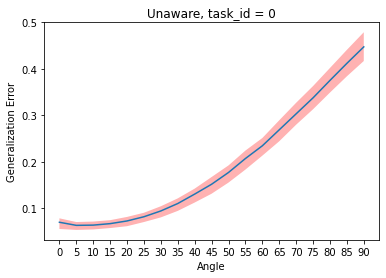

In [6]:
##### plot for mult reps of the exp with error bars #####

# fig, (ax1, ax2, ax3) = plt.subplots(3)

# add error bars
# qunatiles_t1 = np.nanquantile(pl_ge, [0.25, 0.75], axis=0)
# qunatiles_t0 = np.nanquantile(pl_ge_t0, [0.25, 0.75], axis=0)


# fig, (ax1, ax2) = plt.subplots(2)
# ax1.plot(angle_sweep, np.mean(pl_ge,axis=0))  # task_id = task
# ax1.set_title("task_id = task")
# ax1.set_ylabel("Generalization Error")
# ax1.fill_between(
#    angle_sweep, qunatiles_t1[0], qunatiles_t1[1], facecolor="r", alpha=0.3
# )
# ax2.plot(angle_sweep, np.mean(pl_ge_t0,axis=0))  # task_id = 0
# ax2.set_title("task_id = 0")
# ax2.set_xlabel("Angle")
# ax2.set_ylabel("Generalization Error")
# fig.tight_layout()

# ax2.fill_between(
#    angle_sweep, qunatiles_t0[0], qunatiles_t0[1], facecolor="r", alpha=0.3
# )


qunatiles_t0 = np.nanquantile(pl_ge_t0, [0.25, 0.75], axis=0)
plt.fill_between(
    angle_sweep, qunatiles_t0[0], qunatiles_t0[1], facecolor="r", alpha=0.3
)
plt.plot(angle_sweep, np.mean(pl_ge_t0, axis=0))  # task_id = 0
plt.title("Unaware, task_id = 0")
plt.xlabel("Angle")
plt.ylabel("Generalization Error")
plt.xticks(np.arange(min(angle_sweep), max(angle_sweep) + 5, 5))

# Task aware for multiple reps

In [7]:
# number of times to run exp
mc_reps = 1000
# arrays to store gen error
# aware_pl_ge = np.zeros([mc_reps, 19])
aware_pl_ge_t0 = np.zeros([mc_reps, 19])

In [8]:
for i in range(mc_reps):
    # generate task xor
    X_xor, y_xor = generate_gaussian_parity(n_samples)
    # generate test data
    X_xor_test, y_xor_test = generate_gaussian_parity(test_samples)
    # init the aware progressive learner
    aware_progressive_learner = LifelongClassificationForest(default_n_estimators=n_trees)
    # add xor data as first task
    aware_progressive_learner.add_task(X_xor, y_xor, n_estimators=n_trees)   
    
    ##### task aware experiment #####
    # loop through the angle range and add each new rxor as a new task
    # calc gen errors for test xor using first task (task_id=0)
    for rep, angle in enumerate(angle_sweep):
        # generate rxor data
        X_rxor, y_rxor = generate_gaussian_parity(n_samples, angle_params=np.radians(angle))
        # add as new data as task
        aware_progressive_learner.add_task(X_rxor, y_rxor, n_estimators=n_trees)
        #aware_progressive_learner.add_transformer(X_rxor, y_rxor, n_estimators=n_trees)

        # calc gen errors per angle rxor
        # aware_pl_ge[i] = 1 - np.mean(
        #     aware_progressive_learner.predict(X_xor_test, task_id=1) == y_xor_test
        # )
        aware_pl_ge_t0[i, rep] = 1 - np.mean(
            aware_progressive_learner.predict(X_xor_test, task_id=0) == y_xor_test
        )

([<matplotlib.axis.XTick at 0x1c990931550>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

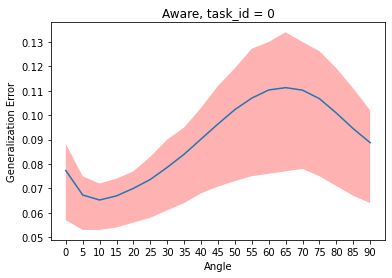

In [9]:
# plot with error bars
aware_qunatiles_t0 = np.nanquantile(aware_pl_ge_t0, [0.25, 0.75], axis=0)
plt.fill_between(
    angle_sweep, aware_qunatiles_t0[0], aware_qunatiles_t0[1], facecolor="r", alpha=0.3
)
plt.plot(angle_sweep, np.mean(aware_pl_ge_t0, axis=0))  # task_id = 0
plt.title("Aware, task_id = 0")
plt.xlabel("Angle")
plt.ylabel("Generalization Error")
plt.xticks(np.arange(min(angle_sweep), max(angle_sweep) + 5, 5))